# Grupo 2

Benitez, Macarena<br>
Castro Luna, Eduardo<br>
Gutierrez, Federico<br>
Wolowski, Mauro

# 1. Importación de Librerías y Configuraciones Iniciales

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from missingno import matrix, heatmap
from sklearn.model_selection import train_test_split

from tp2_utils import *

# Configuracion de pandas

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/home/edu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


tp2_utils contiene funciones útiles para este trabajo, las que, para limpieza de este notebook, se prefirió mantener en una librería a importar.

En los submódulos de la librería podemos encontrar:
- df_categorical_transformations_utils y df_numerical_transformations: transformacions básicas al dataset identificadas en el trabajo anterior (con algunas modificaciones, como se detalla abajo) para la curación de los datos. Estas son usadas en las secciones 3 y 4.
- variables_classification: Contiene claseVariablesClassification, que permite acceder a la clasificación de las variables realizada en el TP1.
- df_exploration_utils: Funciones útiles para explorar los datos, usadas para explicar algunas decisiones.
- df_rows_and_columns_remove: Funciones para la eliminación de filas y columnas nulas o consideradas irrelevantes.

# 2. Importación de base de datos original

In [10]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)

# 3. Curación de los Datos Categóricos

Aplicamos las mismas transformaciones realizadas en el Trabajo Práctico 1, con algunas modificaciones:

- Cambiar datos en formato serial de excel a formato dd/mm/yyyy
- Convertir todos los datos de tiempo a objetos pandas DataFrame, imputando los valores no válidos (cadenas del estilo 'no se midió) como NaT
- Pasamos todos los valores de campaña a minúscula. Eliminamos los que no correspondan a 'verano', 'otoño', 'invierno', 'primavera'
- En aquellas columnas que sólo admiten valores Asencia/Presencia -o similares-, imputamos como None aquellos valores que no correspondan a alguna de las categorías. Además, uniformamos los valores a 1 y 0 (a diferencia de lo hecho en el TP1, en el que seteamos a todos los valores válidos como'Ausente'/'Presente')
- Se imputan como None aquellos valores no válidos en calidad_de_agua
- Se imputan como NaN los valores no válidos en año -no hecho en TP 1-.
- Imputamos los datos faltantes relacionados con el Censo de 2022 y el Programa de Estudios del Conurbano usando la variable 'codigo':
    - Todas estas variables, salvo longitud y latitud, son imputadas usando sólo los dos primeros caracteres del código
    - Latitud y longitud no son imputadas, puesto que se observa que hay una correspondencia biunívoca entre latitud, longitud y código. No podemos asignar un único valor de latitud y longitud a cada municipio.

In [3]:
df1 = apply_date_correction_to_df(df) # Corrección columna 'fecha'
df2 = correct_campana(df1) # Corrección columna 'campaña'
df3 = correct_binary_categorical(df2) # Corrección de variables categóricas binarias
df4 = correct_calidad_del_agua(df3) # Corrección de variable calidad_de_agua
df5 = correct_year(df4) # Corrección variable año
df6 = imputation_per_muni(df5)

# Guardamos el nuevo df para no tener que volver a correr todo esto cada vez
df6.to_csv('./aguas_limpieza_solo_categoricas.csv', index=False)

Columna 'fecha' corregida
Columna 'camapaña' corregida
Columnas olores, color, espumas, mat_susp corregidas
Columna 'calidad_de_agua' corregida
Columna 'año' corregida
Imputación de variables de Censo y Programa de Conurbano -excepto longitud y latitud- usando código realizada


/home/edu/Facultad/DiploDatos/mentorias/TP2/TP2_version_2/tp2_utils/df_categorical_transformations_utils.py:84: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df1['campaña'].astype(str).str.contains(patron, na=False)


# 4. Curación de los Datos Numéricos

In [3]:
# Importamos dataset exportado en la sección anterior, a fin de no tener que volver a correr las celdas anteriores
df6 = pd.read_csv('./aguas_limpieza_solo_categoricas.csv', low_memory=False)

In [13]:
# Veamos con más detalle los valores en cada columna numérica con símbolos '<' y '>' y los comparemos con otros
    # valores de referencia de la misma columna
classifier = VariablesClassification()
numericas = classifier.numericas
for col in numericas:
    numerical_col_data(df6, col)

tem_agua 

No presenta valores con '<' 0 '>'
Mínimo: 6.0, Máximo: 29.4, Media: 19.44606490872211, Mediana: 19.6, Desviación Estándar: 5.008036867283525

---------------------------------------------------
tem_aire 

No presenta valores con '<' 0 '>'
Mínimo: 4.0, Máximo: 33.0, Media: 18.325258799171845, Mediana: 18.0, Desviación Estándar: 6.3286629533640335

---------------------------------------------------
od 

No presenta valores con '<' 0 '>'
Mínimo: 0.2, Máximo: 17.61, Media: 6.246427061310782, Mediana: 6.19, Desviación Estándar: 2.8622443123662444

---------------------------------------------------
ph 

No presenta valores con '<' 0 '>'
Mínimo: 5.0, Máximo: 10.5, Media: 7.509683972911964, Mediana: 7.41, Desviación Estándar: 0.7443493860400554

---------------------------------------------------
colif_fecales_ufc_100ml 

colif_fecales_ufc_100ml_comparison  colif_fecales_ufc_100ml_value
>                                   100000.0                         1
Name: count, dtype: int6

In [14]:
# Veamos cuántos valores encontramos en ciertos intérvalos de valores de algunas columnas (ver análisis en
    # siguiente celda)

col_interval(df6, 'fosf_ortofos_mg_l', minlim=0.1, maxlim=0.2)
col_interval(df6, 'fosf_ortofos_mg_l', maxlim=0.2)
col_interval(df6, 'dbo_mg_l', minlim=2, maxlim=5)
col_interval(df6, 'dbo_mg_l', maxlim=2)
col_interval(df6, 'dqo_mg_l', maxlim=50)
col_interval(df6, 'dqo_mg_l', maxlim=30)
col_interval(df6, 'dqo_mg_l', maxlim=2)
col_interval(df6, 'cr_total_mg_l', minlim=0.01)
col_interval(df6, 'cr_total_mg_l', maxlim=0.01)
col_interval(df6, 'clorofila_a_ug_l', maxlim=10)
col_interval(df6, 'clorofila_a_ug_l', maxlim=0.1)
col_interval(df6, 'clorofila_a_ug_l', maxlim=0.01)
col_interval(df6, 'microcistina_ug_l', maxlim=0.4)
col_interval(df6, 'microcistina_ug_l', maxlim=0.2)

Valores de fosf_ortofos_mg_l mayores a 0.1 y menores a 0.2 : 66 (10.77%)
Valores de fosf_ortofos_mg_l menores a 0.2 : 71 (11.58%)
Valores de dbo_mg_l mayores a 2 y menores a 5 : 163 (26.59%)
Valores de dbo_mg_l menores a 2 : 10 (1.63%)
Valores de dqo_mg_l menores a 50 : 137 (22.35%)
Valores de dqo_mg_l menores a 30 : 53 (8.65%)
Valores de dqo_mg_l menores a 2 : 0 (0.00%)
Valores de cr_total_mg_l mayores a 0.01 : 25 (4.08%)
Valores de cr_total_mg_l menores a 0.01 : 47 (7.67%)
Valores de clorofila_a_ug_l menores a 10 : 156 (25.45%)
Valores de clorofila_a_ug_l menores a 0.1 : 75 (12.23%)
Valores de clorofila_a_ug_l menores a 0.01 : 45 (7.34%)
Valores de microcistina_ug_l menores a 0.4 : 21 (3.43%)
Valores de microcistina_ug_l menores a 0.2 : 11 (1.79%)


En todas las variables numéricas, imputamos como NaN todos los valores no numéricos. Además, se imputan como NaN:

- En **colif_fecales_ufc_100ml**: El valor outlier, muy alejado de los demás valores (mayor a $2\times 10^6$ $UFC/100ml$) y el valor con símbolo '>', dado que es uno sólo y no altera significativamente la información que aporta la columna. 

- En **escher_coli_ufc_100ml**: Los tres outliers (valores por encima de $125.000$ $UFC/100ml$).

- En **enteroc_ufc_100ml**: Los dos valores outliers (mayores a $25.000$ $UFC/100ml$)

- En **nitrato_mg_l**: El valor outlier que se aleja significativamente del resto de los valores (mayor a $25$ $mg/l$) y los valores con símbolo '<', dado que son pocos (`~`7% de los datos, sumando un `~`23% junto con los valores nulos y demás no numéricos).

- En **nh4_mg_l**: El valor outlier, muy alejado de los demás valores (mayor a $25$ $mg/L$) y los valores con símbolo '<', que constituyen el `~`7% de los datos, sumando un `~`23% junto con los valores nulos y demás no numéricos.

- En **p_total_l_mg_l**: El valor outlier, muy alejado del resto de los valores (mayor a $5$ $mg/l$) y los 15 valores con símbolo '<', que representan `~`2% de los datos, sumando un `~`22% de los datos junto con los demás valores no numéricos y nulos.

- En **fosf_ortofos_mg_l**: Los dos valores outliers más alejados del conjunto de datos (mayores a $2$ $mg/l$) y los valores con símbolo '<', que constituyen aproximadamente el `~`8% de los datos totales, sumando junto con los demás no numéricos y los valores nulos un `~`35% de los datos. Si bien este porcentaje de datos faltantes (luego de estas imputaciones) es más considerable comparado con el de las columnas anteriores, sigue siendo lo suficientemente bajo como para considerar imputarlos si no alteran demasiado la distribución de los datos. Por otro lado, los números que se observan junto con el signo '<' son 0.1 y 0.2, y son en total 48. En la columna tenemos 71 valores numéricos (`~`12% del total) menores a $0.2$ $mg/l$, y 66 (`~`11%) entre $0.1$ $mg/l$ y $0.2$ $mg/l$, por lo que quitarle el signo '<' a los valores que lo tienen o imputarlos como cero alteran significativamente las distribución de la variable (como se vió en el TP1). Dado que tenemos muchos valores cercanos a $0.1$ $mg/l$ y $0.2$ $mg/l$, no encontramos prudente otra forma de imputación.

- En **dbo_mg_l**: El valor outlier (mayor a $25$ $mg/l$), muy alejado del resto de los valores, y los valores con símbolo '<'. Si bien estos últimos representan aproximadamente el 16% de los datos, llegando a sumar un `~`45% junto con los demás valores no numéricos y nulos (una proporción más considerable que en casos anteriores y que puede significar la necesidad de descartar la variable), tenemos 163 valores (`~`27%) entre $2$ $mg/l$ y $5$ $mg/l$ y 10 valores menores a $2$ $mg/l$ (1.6%), lo que dificulta imputar los valores '<2' y '<5' presentes en la columna sin alterar significativamente la distribución de los datos.

- En **dqo_mg_l**: Los valores outliers (mayores a $150$ $mg/l$) y los valores con símbolo '<', que constituyen un `~`37% del total de los datos, sumando un `~`63% junto con los demás valores no numéricos y nulos. Si bien estos últimos constituyen un porcentaje muy alto, y el imputar como NaN todos estos valores obliga a eliminar esta columna, tenemos dos motivos para realizar esta imputación en detrimento de cualquier otra: respecto a los valores '<30' y '<50', tenemos una apreciable cantidad de valores menores a $30$ $mg/l$ y $50$ $mg/l$; y respecto a '<2', el valor mínimo de la columna es $2.2$ $mg/l$, muy cercano a 2, lo que nos impide imputar de forma fiable este último valor.

- En **turbiedad_ntu**: El valor outlier (mayor a $300$ $ntu$), y los valores con símbolo '<', que son apenas `~`4% del total de datos, sumando un `~`20% junto con los demás valores no numéricos y nulos.

- En **hidr_deriv_petr_ug_l**: Los valores '<100.0', puesto que los pocos datos que tenemos tienen cierta densidad de datos entre $0$ y $100$ $\mu g/L$.

- En **cr_total_mg_l**: El valor outlier (mayor a $40$ $mg/l$) y los valores con símbolo '<'. Los valores de forma '<5.000', '<100.000' y '<10.000' se consideran sin sentido, por lo que se justifica la decisión de descartarlos (aunque podría especularse con que en realidad estén expresados en $\mu g/l$, lo que explicaría bien los valores, aunque no dejaría de ser una especulación). Los valores '<0.010' se descartan pues se tienen varios valores por debajo y por encima de $0.01$ $mg/l$. Por otro lado, los valores '<0.005', que constituyen el `~`51% de los datos, es muy difícil imputarlos por un valor puesto que los valores numéricos mínimos registrados son muy cercanos a $0.005$ $mg/l$ (aunque superiores), y no puede saberse si es más conveniente imputar esta gran cantidad de valores por valores cercanos, algún valor intermedio entre $0$ $mg/l$ y $0.005$ $mg/l$ o valores varios órdenes de magnitud menores a $0.005$ $mg/l$. Dado que el valor mínimo es $0.0052$ $mg/l$, podría especularse con imputar estos últimos valores con 0.005, entendiendo que así estos valore serían muy similares a los mínimos medidos, sin embargo la poca cantidad de valores numéricos (`~`19% del total de los datos) vuelve imprudente realizar este tipo de medidas.

- En **cd_total_mg_l**: Los valores con símbolo '<'. Todos los valores que tenemos nos llevan a descartar los valores de la forma '<1.000', puesto que este es dos órdenes de magnitud mayor que cualquier valor medido. Respecto al resto de los valores con símbolo '<', los números que acompañan al signo son del mismo orden que los valores numéricos medidos, lo que hace imposible imputar estos de forma adecuada. Además, los valores numéricos sólo representan el `~`2% de los totales, y siendo estos apenas 11 valores, es imposible hacer ninguna asunción de la distribución de esta variable.

- En **clorofila_a_ug_l**: Los valores outliers (mayores a $4000$ $\mu g/l$) y los valores con símbolo '<'. Cuando observamos los valores numéricos más pequeños de la columna (menores a $10$ $\mu g/l$, $0.1$ $\mu g/l$ y $0.01$ $\mu g/l$) observamos valores por encima y por debajo de todos estos, lo que hace muy difícil imputarlos. Esta observación es particularmente importante para el valor '<10.000', que es el más frecuente de los valores con símbolo '<' (149 valores, representando `~`24% del total), puesto que tenemos 156 valores numéricos (el `~`25% de los datos totales) menores a 10.

- En **microcistina_ug_l**: Se eliminan los tres outliers (mayores a $2$ $\mu g/L$) y los valores con símbolo '<'. Estos últimos representan un `~`75% de los valores totales. Esta última imputación obliga a eliminar esta columna, pero, de forma similar al caso de la columna anterior, no tenemos forma de imputar estos valores de forma confiable. El valor '>10.00' y '>5.00' son mayores que todos los valores numéricos medidos. por otro lado, la mayoría de los (pocos) valores medidos son del orden de $0.15$ $\mu g/L$ y $0.20$ $\mu g/L$.
 
Además:

- En **hidr_deriv_petr_ug_l**: No imputamos como NaN los valores outliers, dado que tenemos muy pocos datos numéricos como para saber si realmente son datos atípicos. Los valores '<0.1' se imputan como $0$ $\mu g/l$, dado que son menores al mínimo de $6.9$ $\mu g/L$ que se observa entre los valores numéricos.

Por último, se nota que los valores en 'Poblacion_partido' y 'Personas_con_cloacas' tienen puntos indicando la separación entre cifras de a 3, como es usual en español. Esto hace que, al pasar estos valores a numéricos, sean interpretados como números punto flotantes, salvo por la población de CABA que es interpretada como no numérica al tener dos puntos. Se eliminan los puntos de estos strings antes de pasarlos a valores numéricos.

In [15]:
# Imputamos como NaN los valores outliers
df7 = df6.copy()

cols_con_outliers = ['colif_fecales_ufc_100ml', 'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 'nitrato_mg_l',
                    'nh4_mg_l', 'p_total_l_mg_l', 'fosf_ortofos_mg_l', 'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu',
                    'cr_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l']
outliers_lim = [2E6, 125000, 25000, 25, 25, 5, 2, 25, 150, 300, 40, 4000, 2]

for col, lim in zip(cols_con_outliers, outliers_lim):
    df7 = impute_outliers(df7, col, lim)

Imputación de valores outliers de columna colif_fecales_ufc_100ml -mayores a 2000000.0- completada)
Imputación de valores outliers de columna escher_coli_ufc_100ml -mayores a 125000- completada)
Imputación de valores outliers de columna enteroc_ufc_100ml -mayores a 25000- completada)
Imputación de valores outliers de columna nitrato_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna nh4_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna p_total_l_mg_l -mayores a 5- completada)
Imputación de valores outliers de columna fosf_ortofos_mg_l -mayores a 2- completada)
Imputación de valores outliers de columna dbo_mg_l -mayores a 25- completada)
Imputación de valores outliers de columna dqo_mg_l -mayores a 150- completada)
Imputación de valores outliers de columna turbiedad_ntu -mayores a 300- completada)
Imputación de valores outliers de columna cr_total_mg_l -mayores a 40- completada)
Imputación de valores outliers de columna clorofila_a_ug_l -ma

In [16]:
# Imputamos como 0 los valores '<0.10' en hidr_deriv_petr_ug_l
df8 = df7.copy()
df8 = imput_hidr_01(df8)

Imputación de valores '<0.10', ' <0.10', ' 0.10' y ' 0.20' en columna hidr_deriv_petr_ug_l completada


In [17]:
# Eliminamos los puntos de los valores numéricos en Poblacion_partido y Personas_con_cloacas
df9 = df8.copy()
df9 = remove_dots_in_populations(df9)

Eliminación de puntos en los valores de 'Poblacion_partido' y 'Personas_con_cloacas' completada


In [18]:
# imputamos como NaN los valores no numéricos de las variables numéricas, y transformamos las columnas
    # correspondientes a numéricas
df10 = df9.copy()
df10 = set_to_numerical(df10)

# Guardamos el nuevo df para no tener que volver a correr todo esto cada vez
# df6.to_csv('./aguas_limpieza_final.csv', index=False)
df10.to_csv('./aguas_limpieza_final.csv', index=False)

Imputación de valores no numéricos de variables numéricas completada.


# 5. Curación: Eliminación de Columnas y Filas

In [43]:
# Cargamos el dataset obtenido del paso anterior, para evitar tener que volver a correr las celdas anteriores:
df10 = pd.read_csv('./aguas_limpieza_numericas_y_categoricas.csv', low_memory=False)

En esta sección procederemos a eliminar registros y columnas que consideremos innecesarios para nuestro porpósito o que tengan una gran cantidad de datos faltantes. También eliminaremos registros duplicados. A continuación se brindan más detalles de las decisiones:

- Como se observó en el TP1, los registros duplicados* tienen todos los valores en las variables fisico-químicas y temporales, así como tambien en ICA y calidad_del_agua, como faltantes. Se decide eliminar todos los registros con todos los valores en las variables numéricas continuas y categóricas binarias como faltantes (ignorando latitud y longitud que, como se explica después, se consideran irrelevantes).
- Se eliminan las columnas consideradas irrelevantes para nuestro trabajo:
    - 'orden',
    - 'sitios',
    - 'fecha',
    - 'calidad_de_agua',
    - 'gobierno_local',
    - 'sitio',
    - 'latitud',
    - 'longitud',
    - 'Actividad_principal',
    - 'Agricultura, ganadería, caza y silvicultura',
    - 'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    - 'Explotación de minas y canteras',
    - 'Industria Manufacturera',
    - 'Electricidad, gas y agua',
    - 'Construcción',
    - 'Servicios'
- Se eliminan aquellas columnas cuyo porcentaje de datos faltantes sea superior al 40%.
- Se eliminan registros con valores faltantes en 'ica'.

*<u>Nota</u>: A diferencia del TP1, con las nuevas imputaciones se pasa a tener de 18 a 23 filas duplicadas.

In [44]:
# Eliminación de registros que tengan todos sus valores en las columnas numéricas continuas y categóricas binarias
    # como faltantes (incluyen todas las columnas duplicadas)
df11 = remove_null_rows(df10)

Se eliminaron 89 registros nulos.


In [45]:
# Eliminamos columnas consideradas irrelevantes
irrelevant_cols = [
    'orden',
    'sitios',
    'fecha',
    'calidad_de_agua',
    'gobierno_local',
    'sitio',
    'latitud',
    'longitud',
    'Actividad_principal',
    'Agricultura, ganadería, caza y silvicultura',
    'Pesca explotación de criaderos de peces y granjas piscícolas y servicios conexos',
    'Explotación de minas y canteras',
    'Industria Manufacturera',
    'Electricidad, gas y agua',
    'Construcción',
    'Servicios'
]
df12 = df11.drop(irrelevant_cols, axis=1)

In [46]:
# Veamos cuántos qué porcentaje de datos faltantes tenemos por columna y eliminemos las que superen un 40%
df13 = remove_columns_with_too_many_sull(df12, 40)

Columna			Porcentaje de Nulos
codigo                      0.000000
año                         0.190840
campaña                     0.190840
tem_agua                    5.916031
tem_aire                    7.824427
od                          9.732824
ph                         15.458015
olores                      0.000000
color                       0.000000
espumas                     0.000000
mat_susp                    0.000000
colif_fecales_ufc_100ml     8.015267
escher_coli_ufc_100ml       6.679389
enteroc_ufc_100ml           6.679389
nitrato_mg_l               10.496183
nh4_mg_l                    9.160305
p_total_l_mg_l              9.351145
fosf_ortofos_mg_l          24.045802
dbo_mg_l                   36.259542
dqo_mg_l                   57.251908
turbiedad_ntu               6.106870
hidr_deriv_petr_ug_l       24.427481
cr_total_mg_l              86.259542
cd_total_mg_l              97.900763
clorofila_a_ug_l           47.519084
microcistina_ug_l          92.748092
ica     

In [54]:
# Eliminamos filas con valor nulo en 'ica'
df14 = df13.dropna(subset=['ica'])
print(f"Se eliminan {len(df13)-len(df14)} filas con valor nulo en 'ica'. Nos quedan en total {len(df14)} de las 613 filas originales.")

Se eliminan 15 filas con valor nulo en 'ica'. Nos quedan en total 509 de las 613 filas originales.


In [55]:
df14.to_csv('./aguas_limpias_curacion_final.csv', index=False)

# 6. División del Dataset

- Se usa ICA como variable objetivo para regresión.
- Se realiza la división en train (70%), validación (20%), y test (10%).

In [57]:
# 1. Leer el dataset limpio desde CSV
df14 = pd.read_csv("aguas_limpias_curacion_final.csv")

In [81]:
# 2. Definir variable objetivo
target_col = "ica"
X = df14.drop(columns=[target_col])
y = df14[target_col]

## 3. Dividir en train (70%) y temp (30%)
#X_train, X_temp, y_train, y_temp = train_test_split(
#    X, y, test_size=0.3, random_state=42
#)

# 3. Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Dividir temp en validación (20%) y test (10%)
#X_val, X_test, y_val, y_test = train_test_split(
#    X_temp, y_temp, test_size=0.3333, random_state=42
#)

# 5. Verificar proporciones
total = len(df14)
print(f"Train: {len(X_train)} muestras ({len(X_train)/total:.2%})")
print(f"Test: {len(X_test)} muestras ({len(X_test)/total:.2%})")

Train: 407 muestras (79.96%)
Test: 102 muestras (20.04%)


In [71]:
# Exportamos los datasets
X_train.to_csv('./train_datasets/x_train_inicial.csv', index=False)
y_train.to_csv('./train_datasets/y_train_inicial.csv', index=False)
X_test.to_csv('./test_datasets/x_test_inicial.csv', index=False)
y_test.to_csv('./test_datasets/y_test_inicial.csv', index=False)

# 7. Imputaciones de Variables Numéricas

In [72]:
X_train = pd.read_csv('./train_datasets/x_train_inicial.csv')
y_train = pd.read_csv('./train_datasets/y_train_inicial.csv')
X_test = pd.read_csv('./test_datasets/x_test_inicial.csv')
y_test = pd.read_csv('./test_datasets/y_test_inicial.csv')

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [75]:
# Identificamos columnas numéricas y categóricas.
num = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in num if not 'año' in col]

cat = X_train.select_dtypes(include=['object', 'category']).columns
categorical_cols = list(cat)+['año']

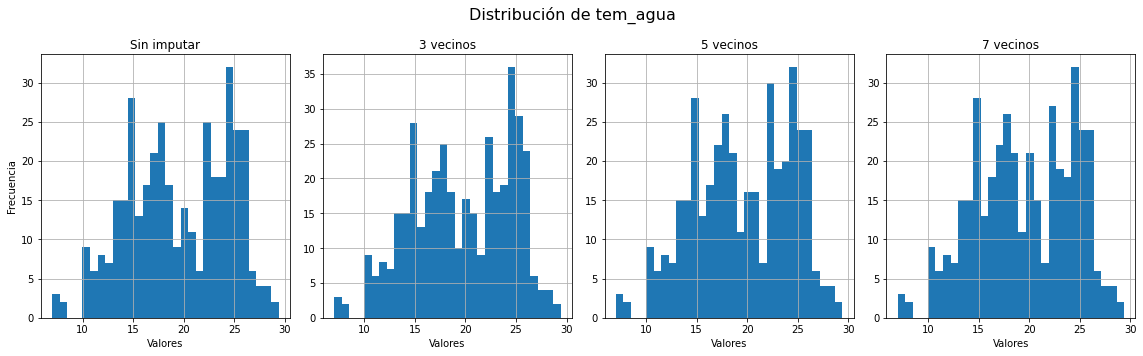

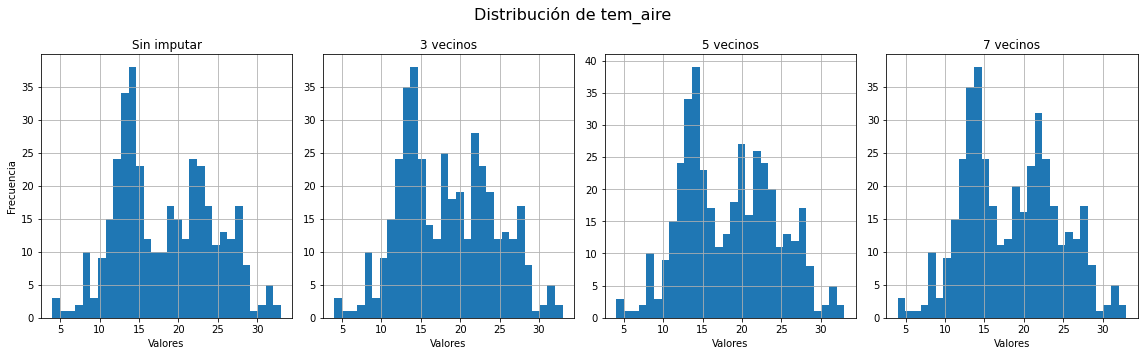

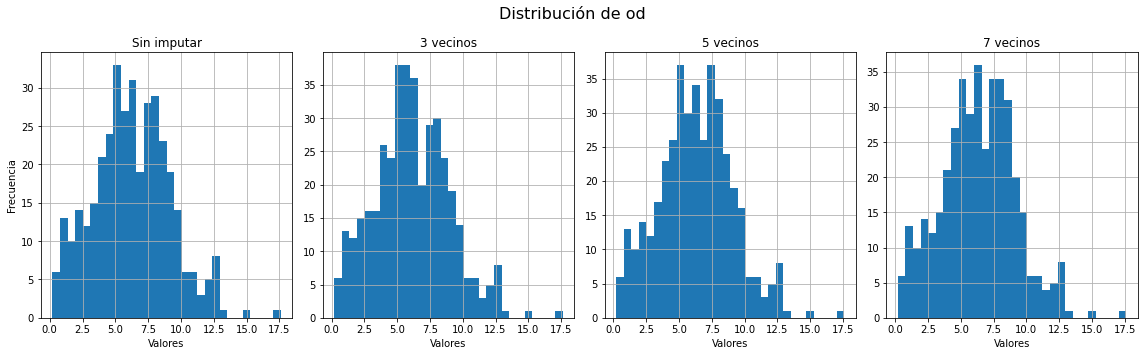

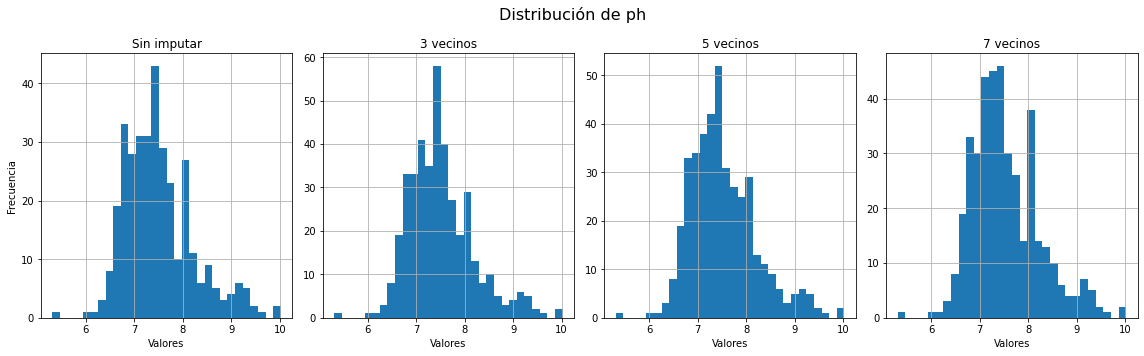

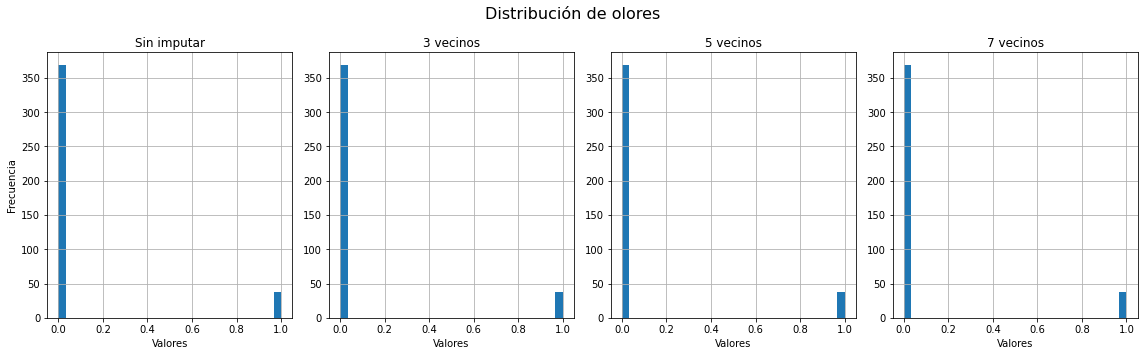

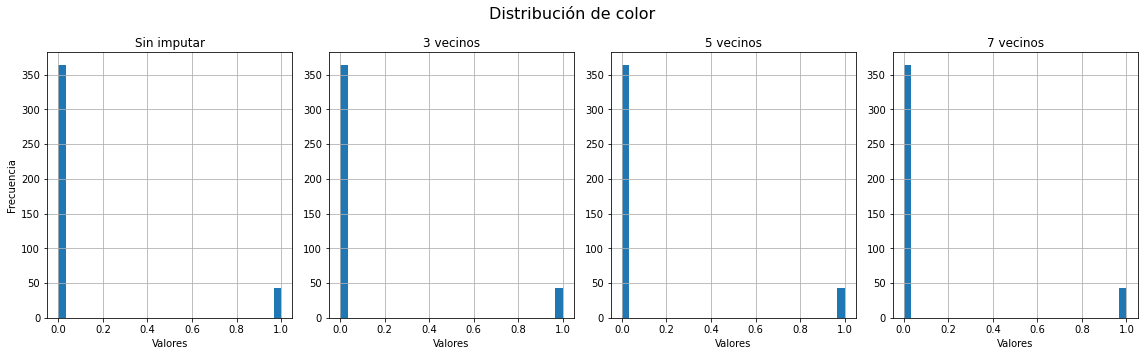

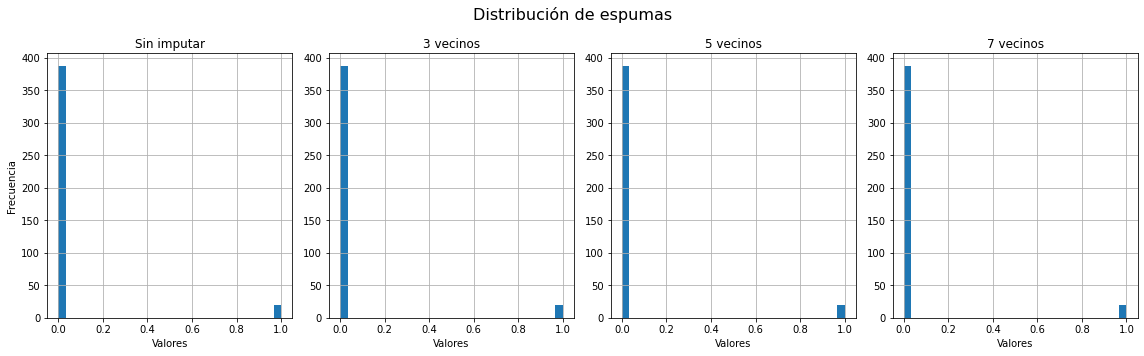

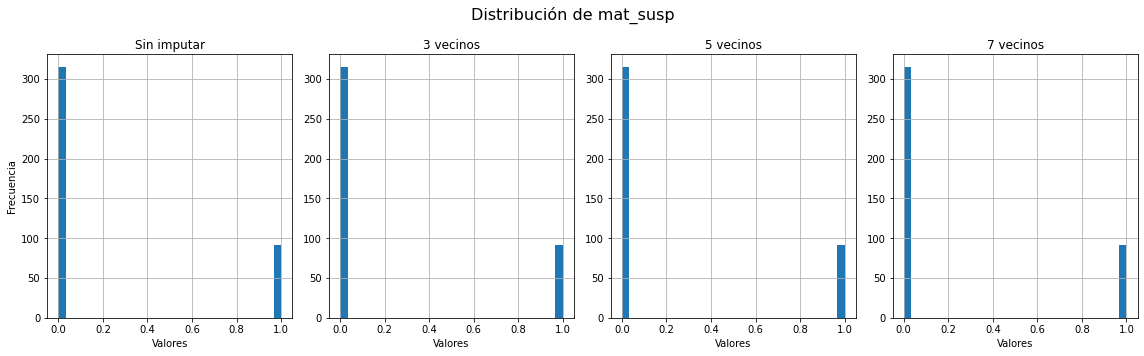

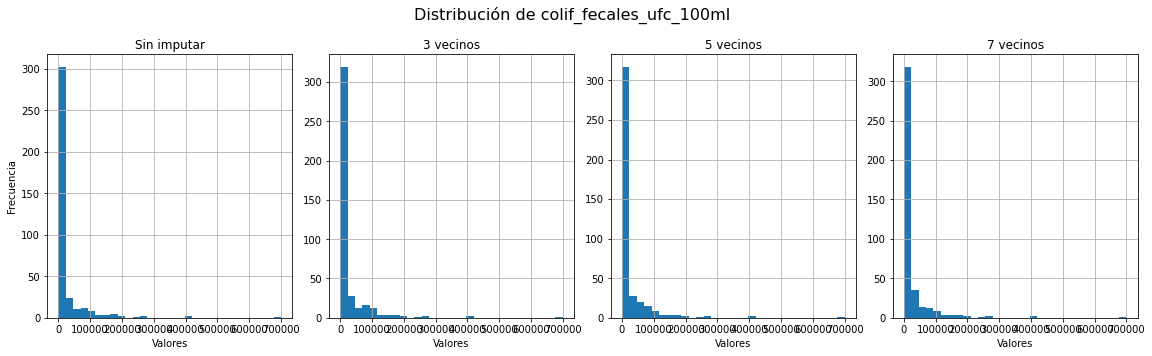

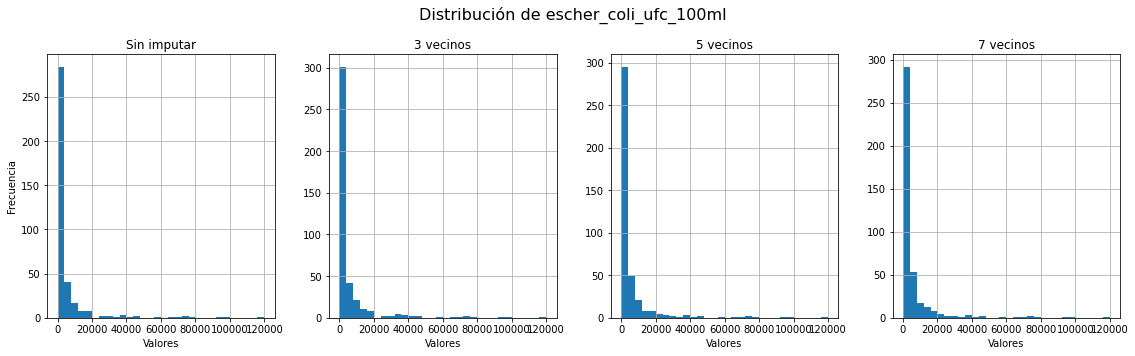

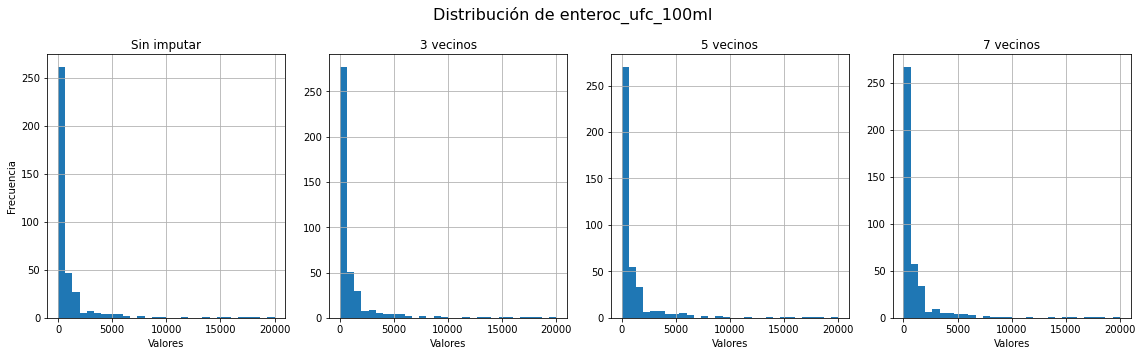

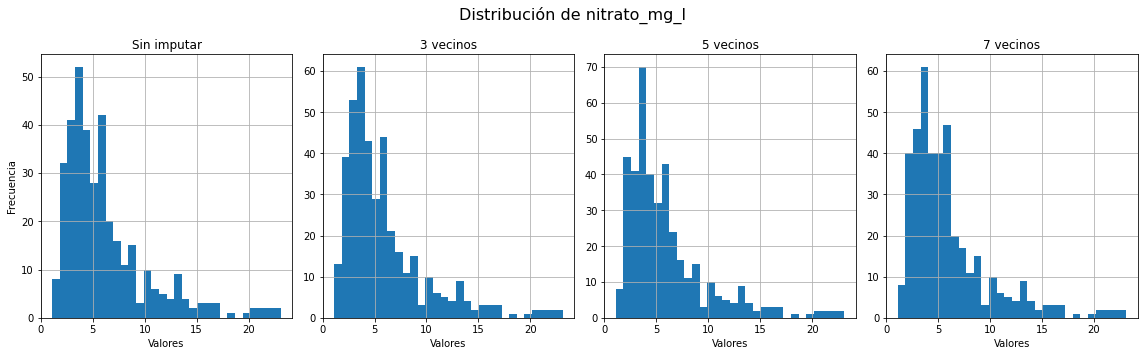

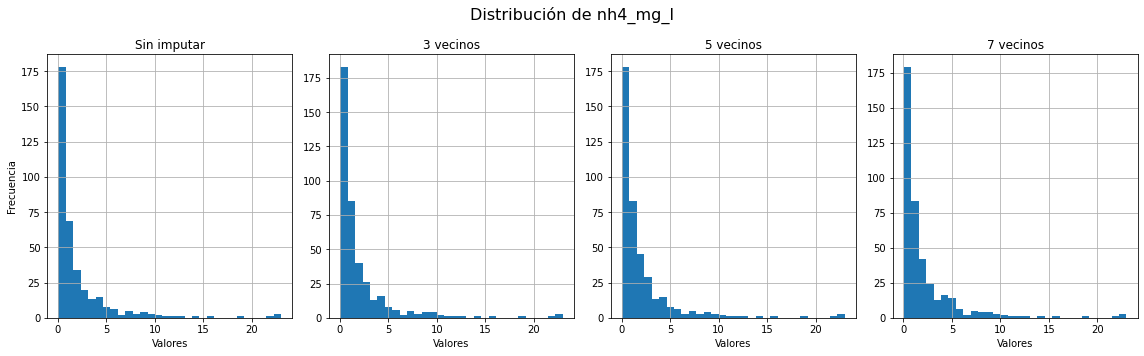

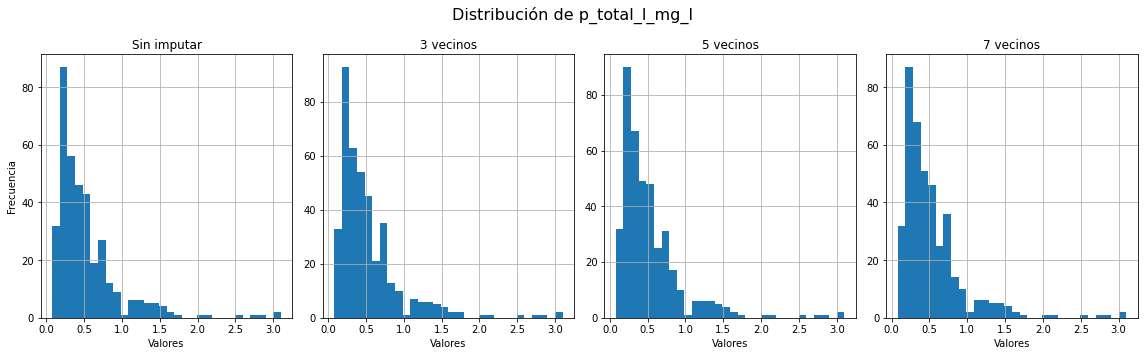

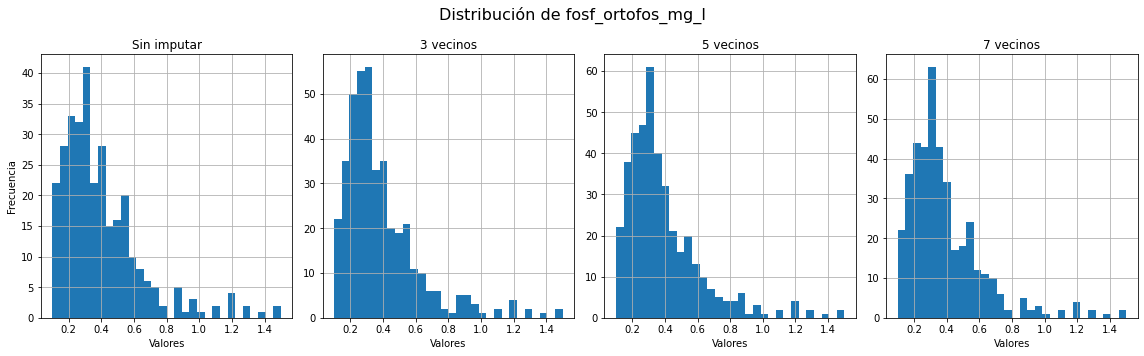

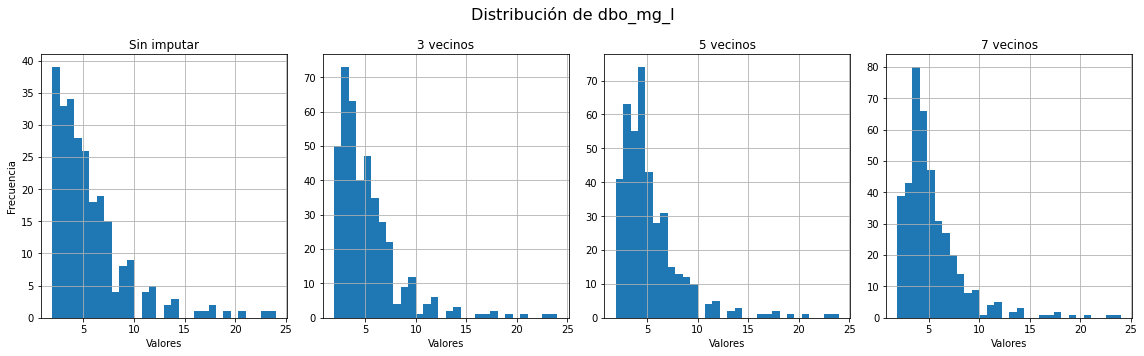

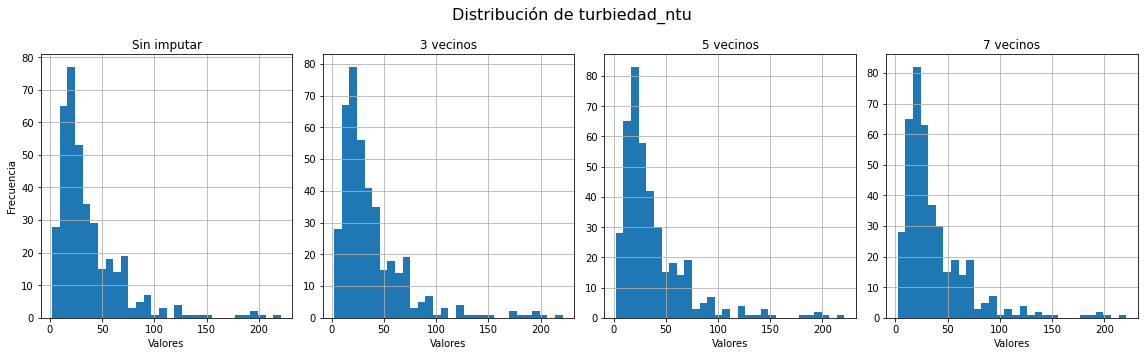

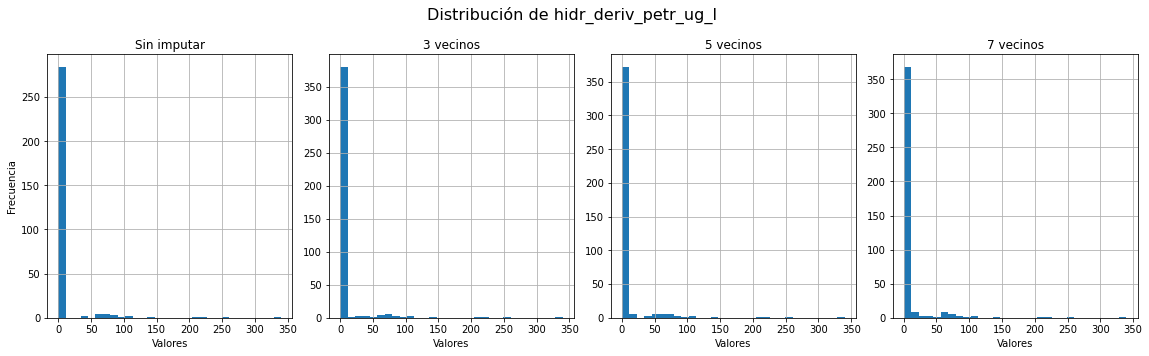

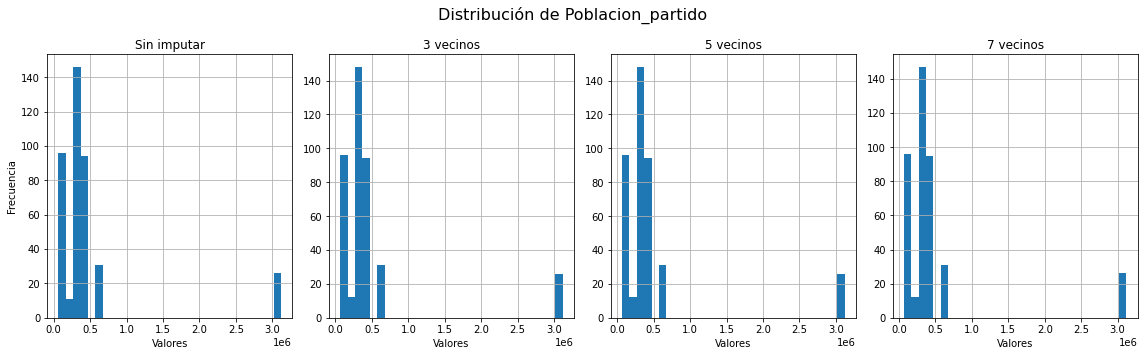

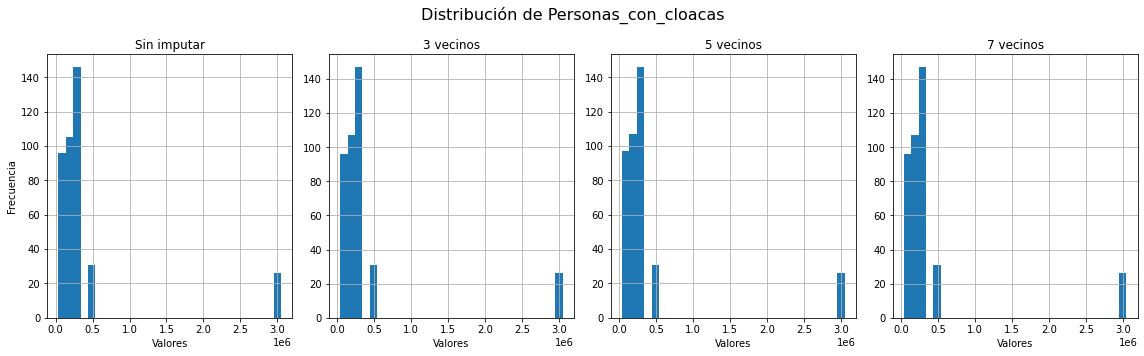

In [82]:
# Probamos dos tipos de imputadores para variables numéricas: KNN y Bayes. Vemos cuál permite conservar mejor la
    # distribución de los datos.

knn_num_imputer_3 = KNNImputer(n_neighbors=3)
knn_num_imputer_5 = KNNImputer(n_neighbors=5)
knn_num_imputer_7 = KNNImputer(n_neighbors=7)
X_train_num_imputed_3 = knn_num_imputer_3.fit_transform(X_train[numerical_cols])
X_train_num_imputed_5 = knn_num_imputer_5.fit_transform(X_train[numerical_cols])
X_train_num_imputed_7 = knn_num_imputer_7.fit_transform(X_train[numerical_cols])

# Convert the imputed array back to DataFrame for easier handling
X_train_num_imputed_3_df = pd.DataFrame(X_train_num_imputed_3, 
                                     columns=numerical_cols,
                                     index=X_train.index)
X_train_num_imputed_5_df = pd.DataFrame(X_train_num_imputed_5, 
                                     columns=numerical_cols,
                                     index=X_train.index)
X_train_num_imputed_7_df = pd.DataFrame(X_train_num_imputed_7, 
                                     columns=numerical_cols,
                                     index=X_train.index)

# Lista de DataFrames y títulos para cada subgráfico
dataframes = [X_train, X_train_num_imputed_3_df, X_train_num_imputed_5_df, X_train_num_imputed_7_df]
titles = ['Sin imputar', '3 vecinos', '5 vecinos', '7 vecinos']

for col in numerical_cols:
    # Crear figura y subgráficos (1 fila, 4 columnas)
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    plt.suptitle(f"Distribución de {col}", fontsize=16)

    # Graficar histogramas para cada DataFrame
    for i, (data, ax, title) in enumerate(zip(dataframes, axes, titles)):
        data[col].hist(bins=30, ax=ax)  # Usar ax=ax para dirigir al subgráfico correcto
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Valores")
        if i == 0:  # Solo añadir etiqueta Y al primer subgráfico para evitar redundancia
            ax.set_ylabel("Frecuencia")

    # Ajustar layout y mostrar
    plt.tight_layout()
    plt.show()

Nos quedamos con el KNN de 7 vecinos. Veamos el bayesiano:

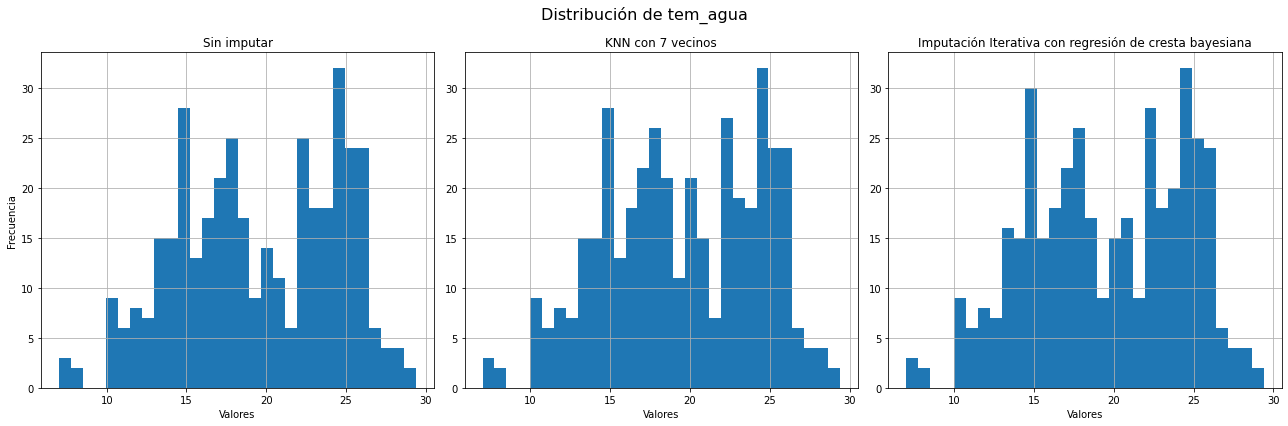

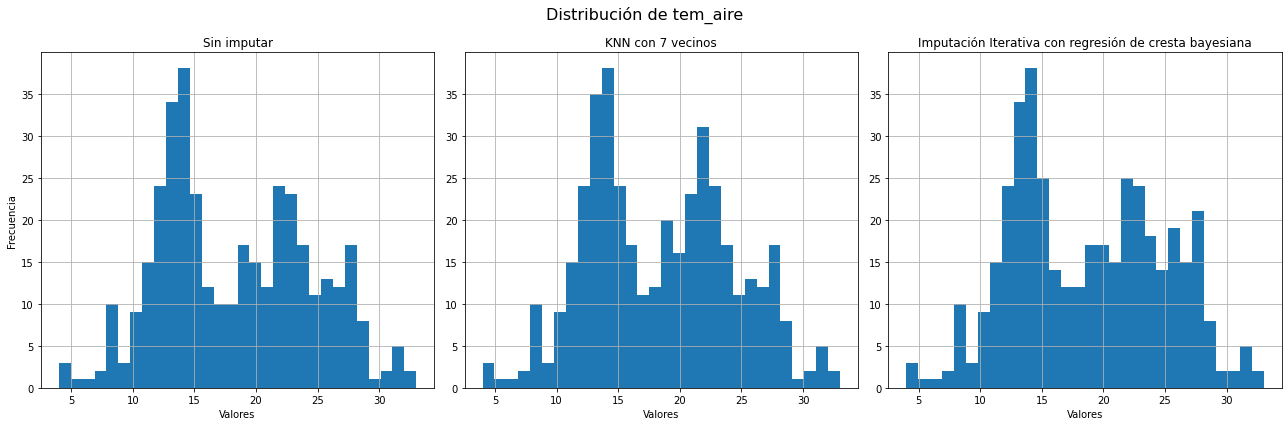

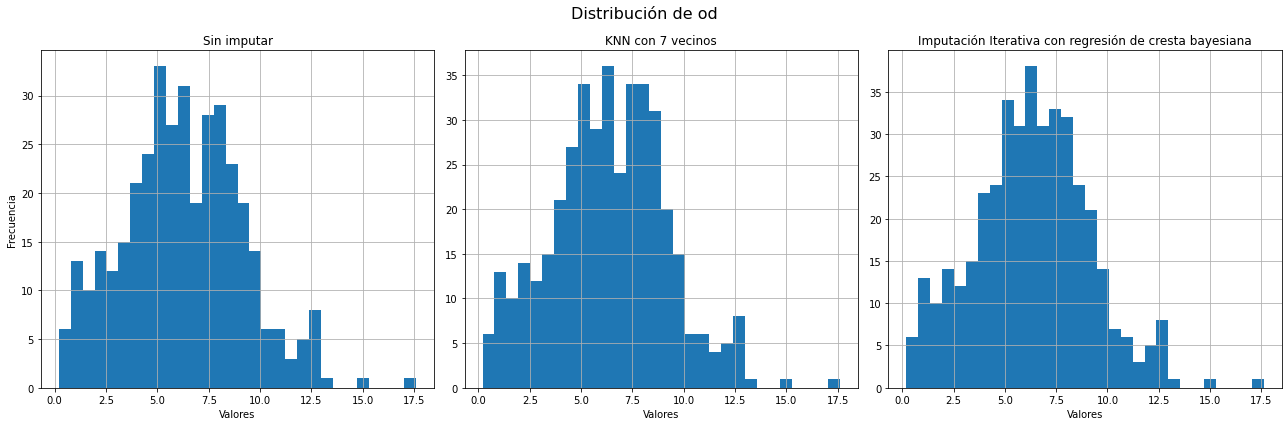

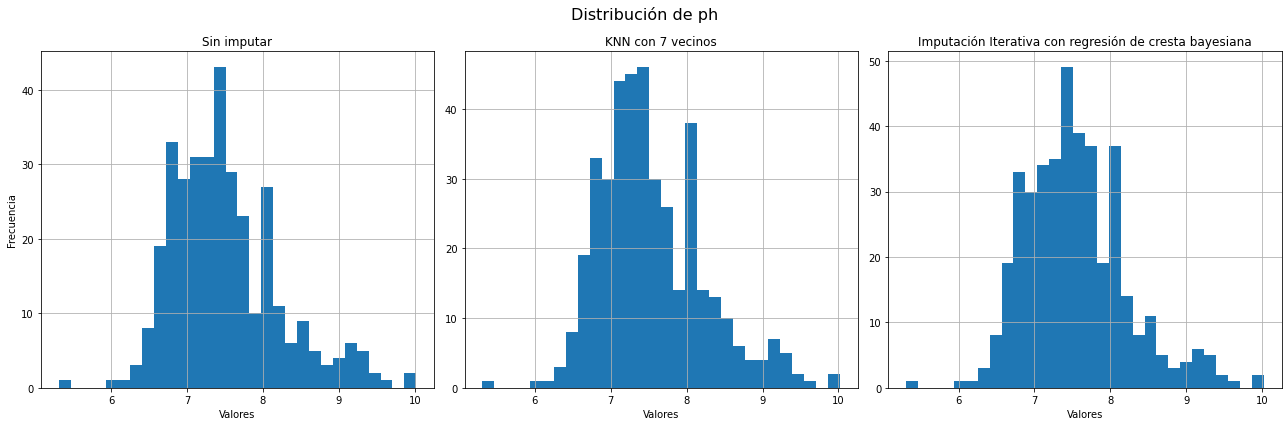

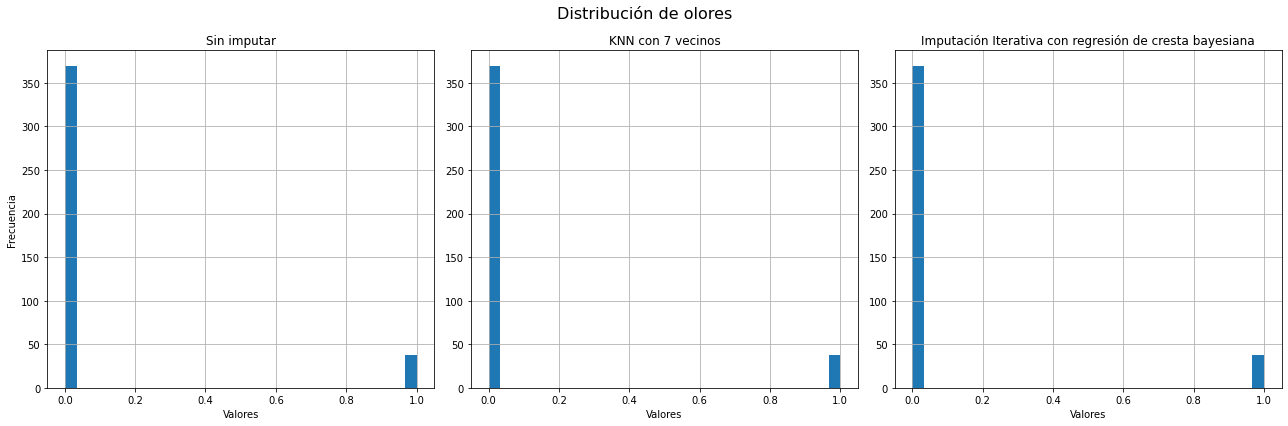

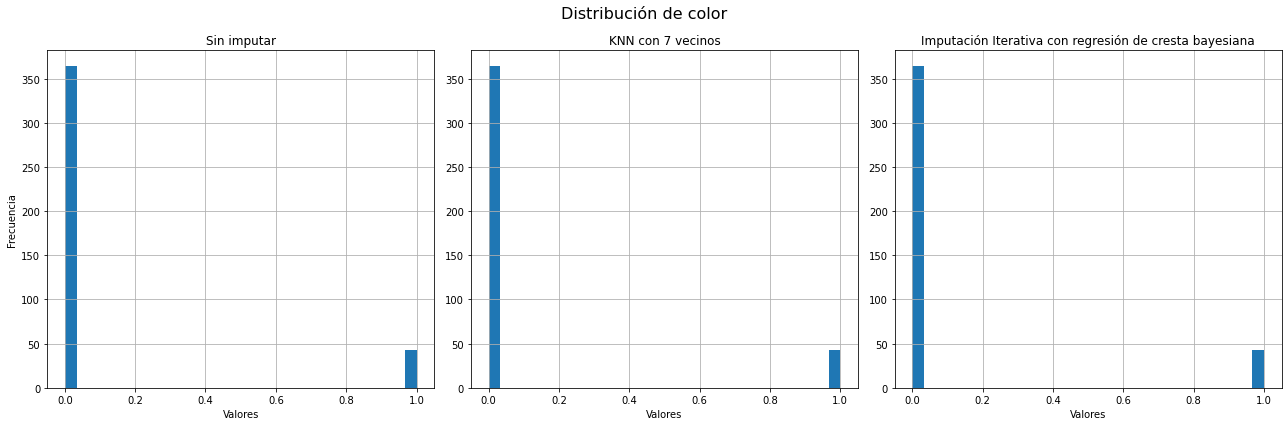

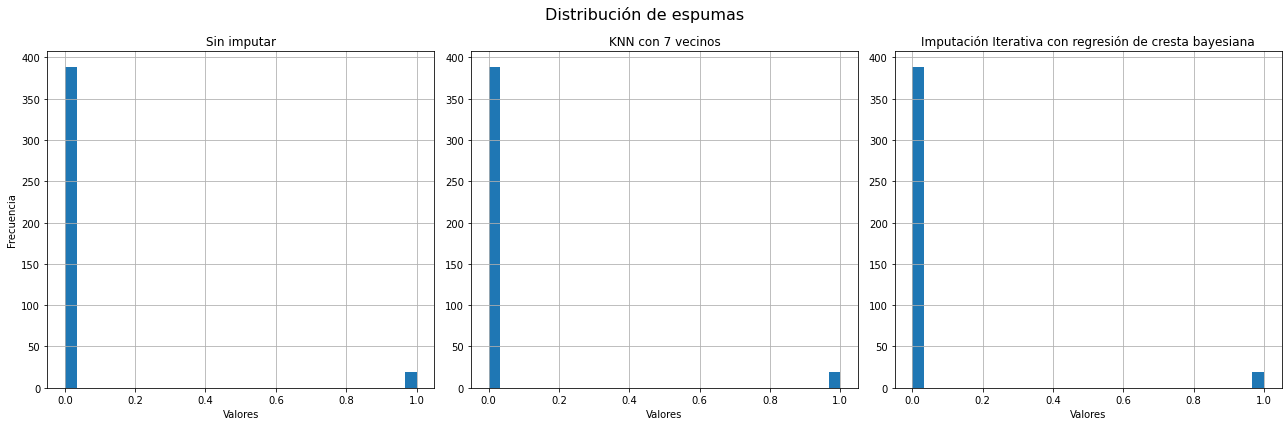

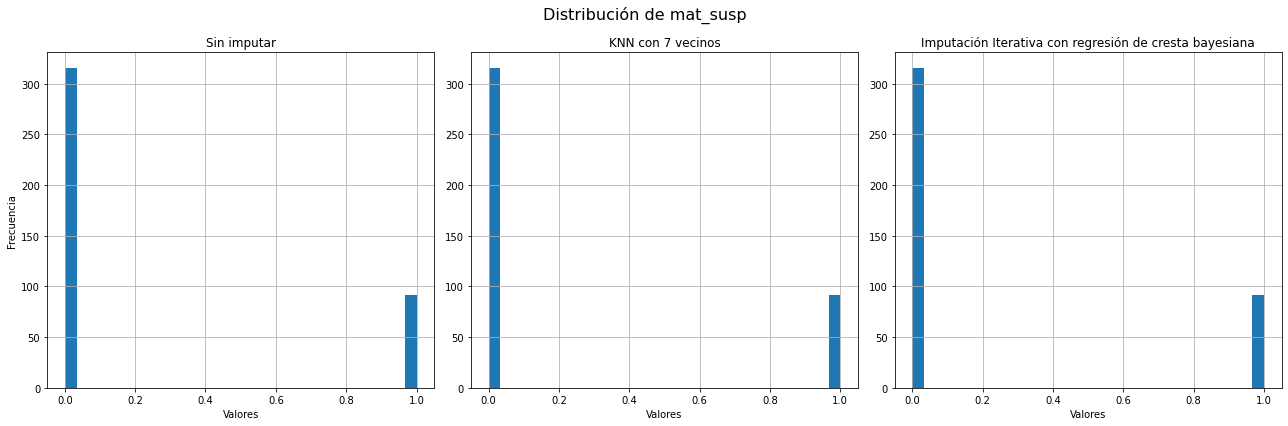

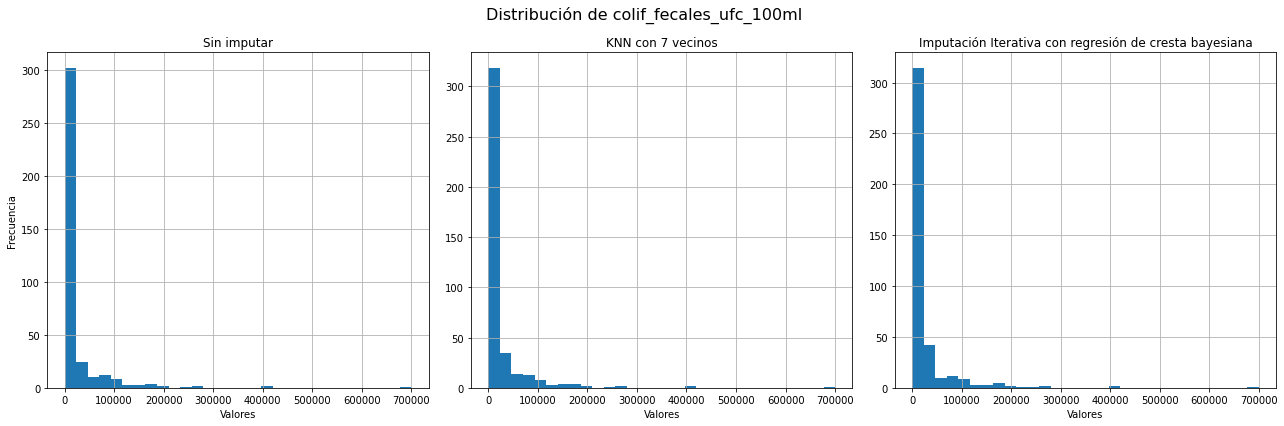

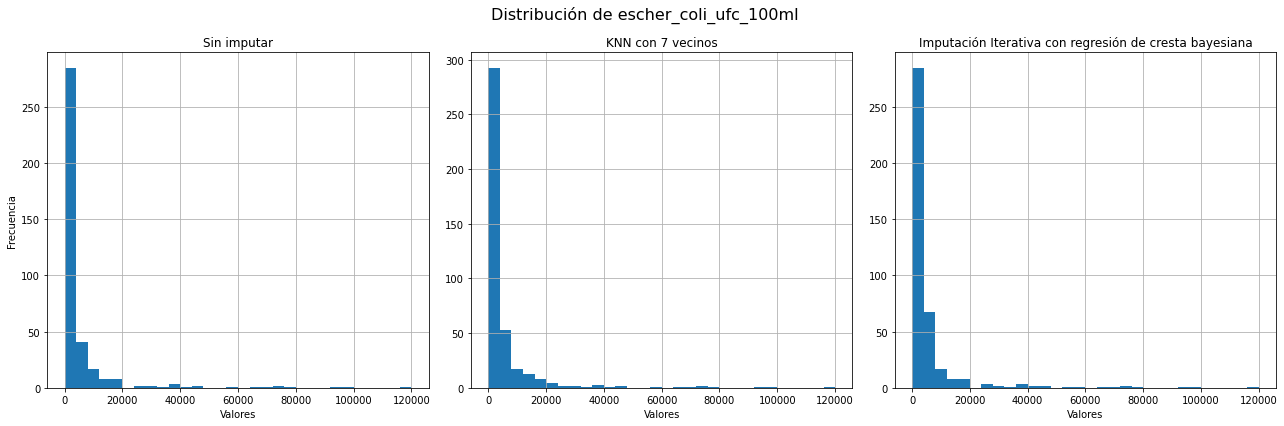

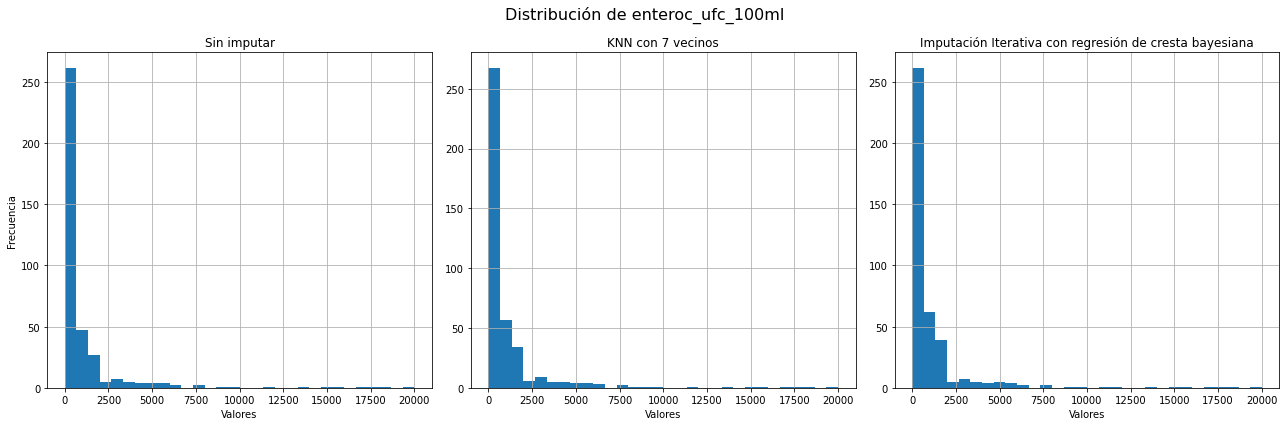

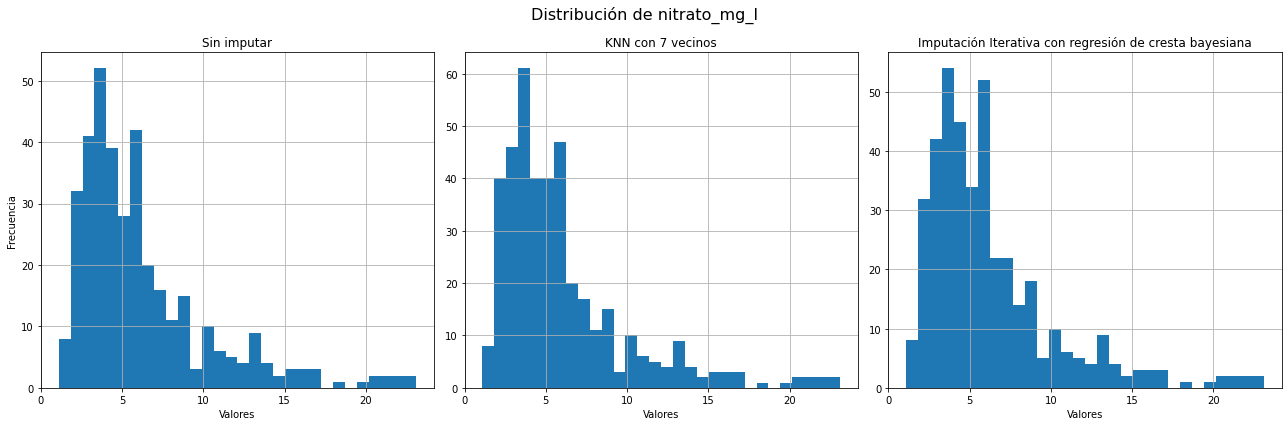

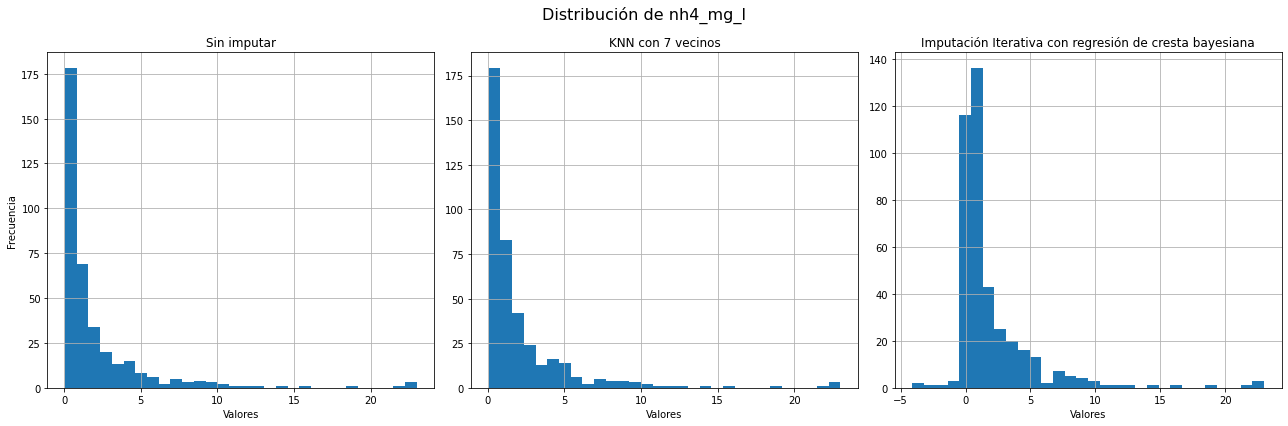

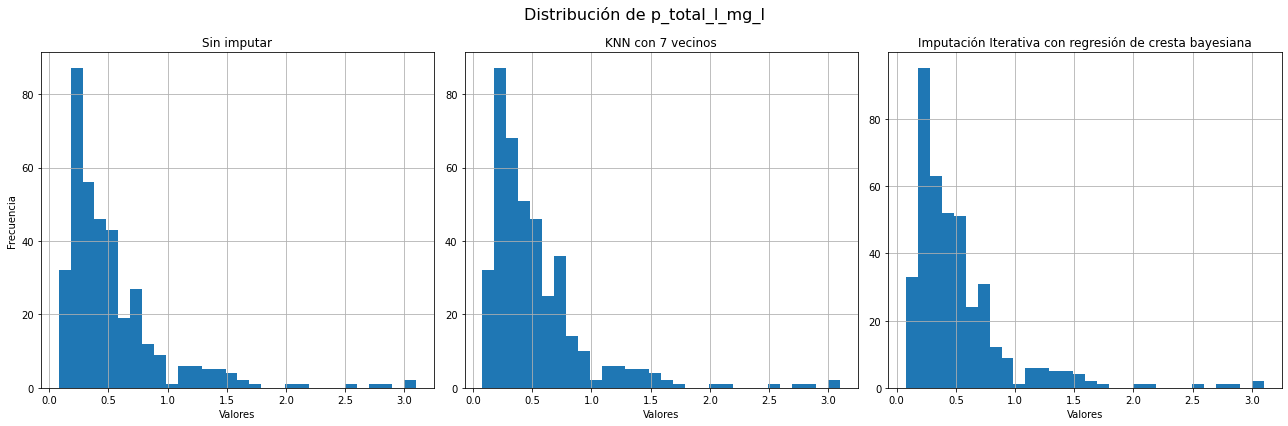

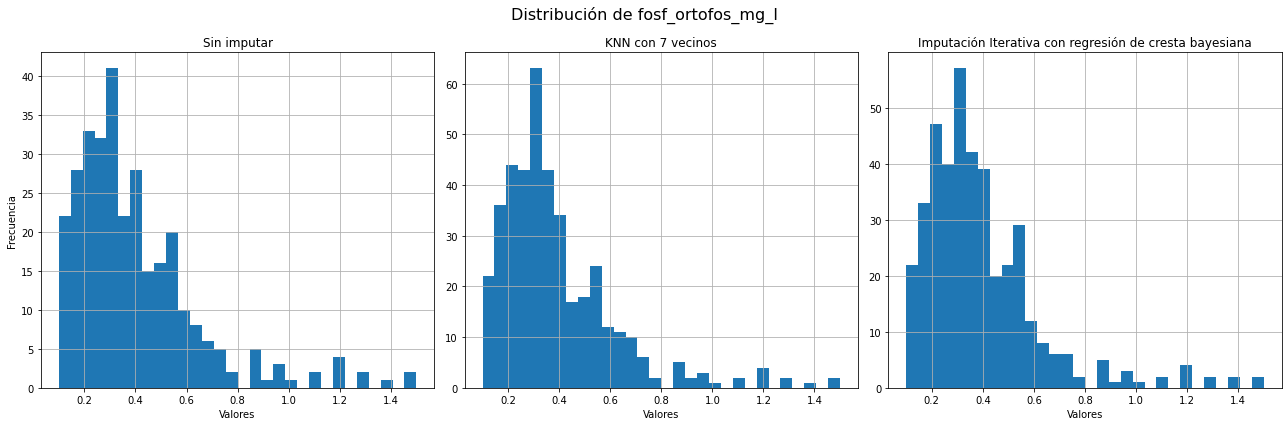

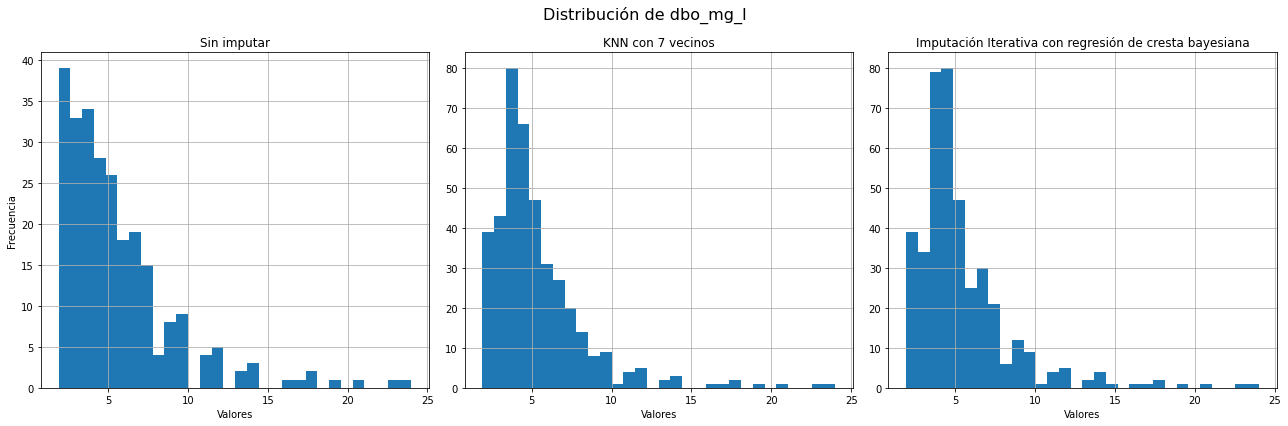

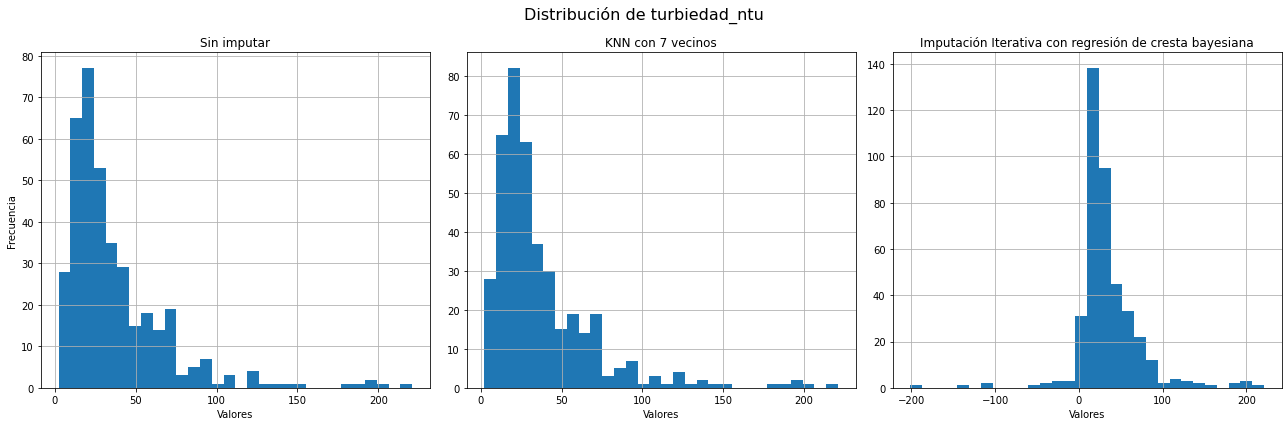

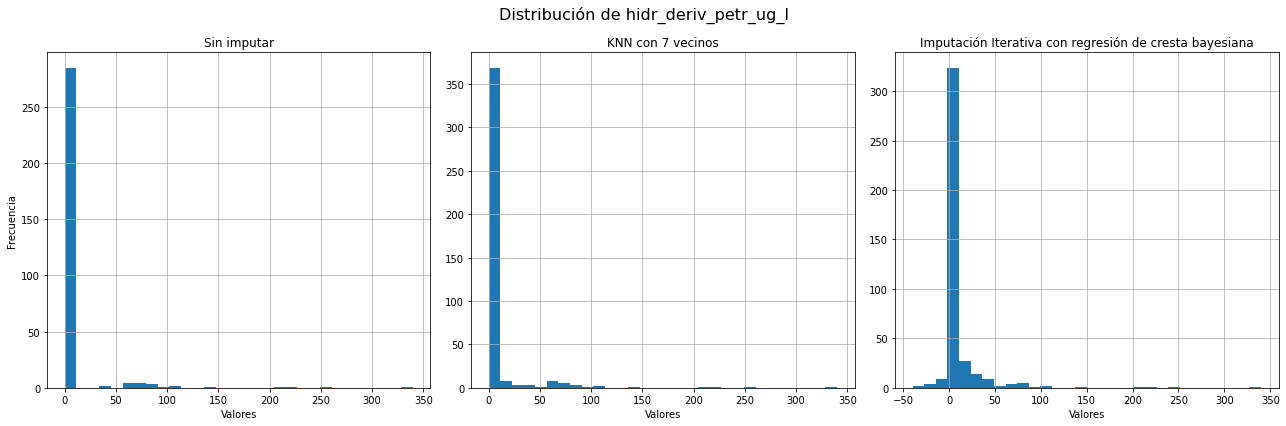

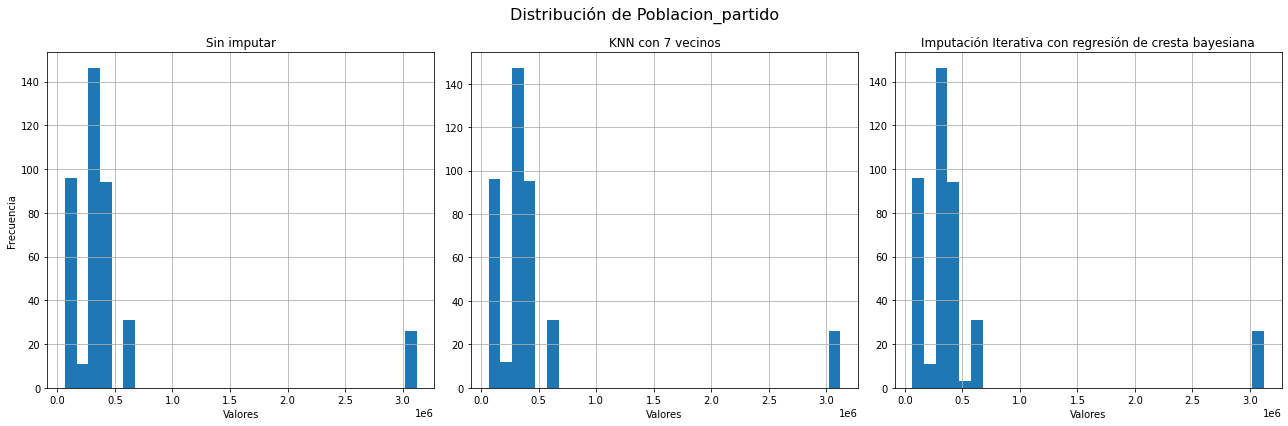

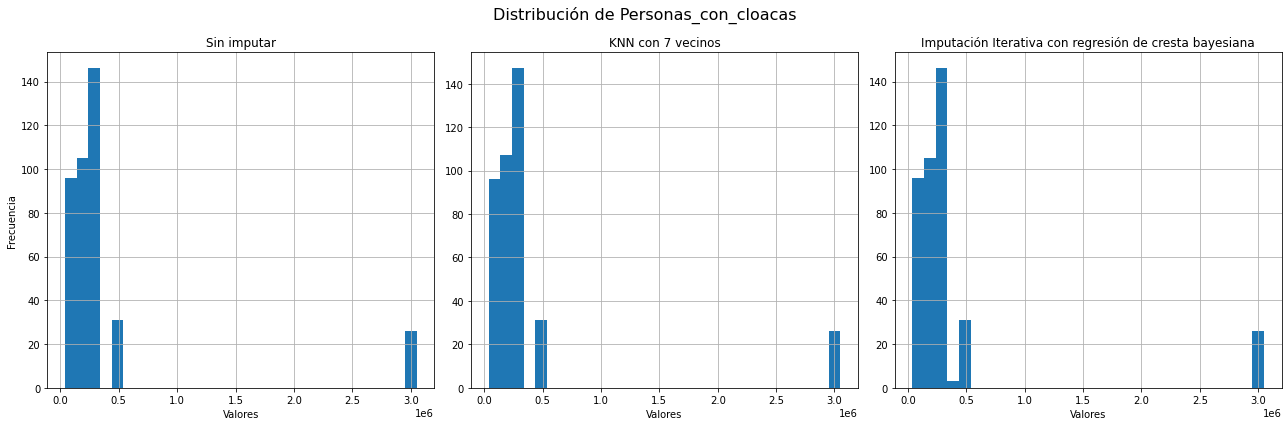

In [86]:
# Probamos dos tipos de imputadores para variables numéricas: KNN y Bayes. Vemos cuál permite conservar mejor la
    # distribución de los datos.
bayes_imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)

X_train_num_imputed_bay = bayes_imputer.fit_transform(X_train[numerical_cols])

# Convert the imputed array back to DataFrame for easier handling
X_train_num_imputed_bay_df = pd.DataFrame(X_train_num_imputed_bay, 
                                     columns=numerical_cols,
                                     index=X_train.index)

# Lista de DataFrames y títulos para cada subgráfico
dataframes = [X_train, X_train_num_imputed_7_df, X_train_num_imputed_bay_df]
titles = ['Sin imputar', 'KNN con 7 vecinos', 'Imputación Iterativa con regresión de cresta bayesiana']

for col in numerical_cols:
    # Crear figura y subgráficos (1 fila, 3 columnas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(f"Distribución de {col}", fontsize=16)

    # Graficar histogramas para cada DataFrame
    for i, (data, ax, title) in enumerate(zip(dataframes, axes, titles)):
        data[col].hist(bins=30, ax=ax)  # Usar ax=ax para dirigir al subgráfico correcto
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Valores")
        if i == 0:  # Solo añadir etiqueta Y al primer subgráfico para evitar redundancia
            ax.set_ylabel("Frecuencia")

    # Ajustar layout y mostrar
    plt.tight_layout()
    plt.show()

In [33]:
cols = ['codigo', 'campaña']

### Crear el encoder. Notar que:
    # drop='first' para evitar multicolinealidad (eliminamos la primer categoría para eliminar la dependencia lineal
        # entre las nuevas columnas).
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Ajustar y transformar los datos
encoded_data = encoder.fit_transform(df14[cols])

# Obtener los nombres de las nuevas columnas
feature_names = encoder.get_feature_names_out(cols)

# Crear un DataFrame con las nuevas columnas
df_encoded = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenar con las columnas numéricas originales
df_final = pd.concat([df14.drop(cols, axis=1), df_encoded], axis=1)

print("\nDataFrame después del One-Hot Encoding:")
print(len(df_final.columns))
print(df_final[:1])


DataFrame después del One-Hot Encoding:
69
      año  tem_agua  tem_aire    od    ph  olores  color  espumas  mat_susp  \
0  2021.0      25.3       NaN  4.77  6.61     0.0    0.0      0.0       0.0   

   colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  \
0                   2000.0                 1320.0              450.0   

   nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  \
0           4.3      0.36             1.0               0.44       NaN   

   turbiedad_ntu  hidr_deriv_petr_ug_l   ica  Poblacion_partido  \
0           45.0                   NaN  45.0           367554.0   

   Personas_con_cloacas  codigo_AV051  codigo_AV052  codigo_AV053  \
0              289059.0           1.0           0.0           0.0   

   codigo_AV054  codigo_AV055  codigo_BS091  codigo_BS092  codigo_BS093  \
0           0.0           0.0           0.0           0.0           0.0   

   codigo_BS094  codigo_BS095  codigo_BZ077  codigo_BZ078  codigo_BZ080  \
0  

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
OneHotEncoder??

---
# Ramas paralelas de experimentación
Se proponen las siguientes ramas iniciales de trabajo:
- Rama A: Conservar todas las variables
- Rama B: Eliminar variables altamente correlacionadas

### Rama A: Conservar todas las variables

In [ ]:
# 6. Guardar dataset sin modificaciones de la división anterior
X_train.to_csv("X_train_ramaB.csv", index=False)
X_val.to_csv("X_val_ramaB.csv", index=False)
X_test.to_csv("X_test_ramaB.csv", index=False)

print("Rama A creada y guardada con éxito.")

### Rama B: Eliminar variables altamente correlacionadas
Eliminar variables numéricas que estén altamente correlacionadas (|r| > 0.85), dejando solo una de cada grupo correlacionado.

In [ ]:
# 1. Calcular matriz de correlación absoluta en X_train
matriz_corr = X_train.select_dtypes(include=[np.number]).corr().abs()

# 2. Crear máscara para triangular superior (evita duplicados)
mascara = np.triu(np.ones(matriz_corr.shape), k=1).astype(bool)
corr_sup = matriz_corr.where(mascara)

# 3. Identificar columnas con correlación > 0.85
columnas_correlacionadas = [col for col in corr_sup.columns if any(corr_sup[col] > 0.85)]

print("Columnas eliminadas por alta correlación:", columnas_correlacionadas)

# 4. Eliminar las columnas de los tres conjuntos
X_train_sin_corr = X_train.drop(columns=columnas_correlacionadas)
X_val_sin_corr = X_val.drop(columns=columnas_correlacionadas)
X_test_sin_corr = X_test.drop(columns=columnas_correlacionadas)

# 5. (opcional) Guardar en CSV para trabajar sobre esta rama
# X_train_sin_corr.to_csv("X_train_ramaB.csv", index=False)
# X_val_sin_corr.to_csv("X_val_ramaB.csv", index=False)
# X_test_sin_corr.to_csv("X_test_ramaB.csv", index=False)

print("Rama B creada y guardada con éxito.")

---
# Imputación

---
# Modelo